In [3]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 42.4 MB/s eta 0:00:00


In [1]:
!pip install pennylane torch torchvision numpy matplotlib


In [2]:
import torch
import torchvision
from torchvision import transforms

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


In [3]:
# Convert images to grayscale (1 channel)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)


Amplitude Encoding (Z-expectation): [np.float64(-0.6451033055782318), np.float64(0.0508592426776886), np.float64(-0.15998363494873047), np.float64(-0.0379461944103241), np.float64(-0.09625190496444702), np.float64(-0.11250543594360352), np.float64(0.046496033668518066), np.float64(-0.011157840490341187)]


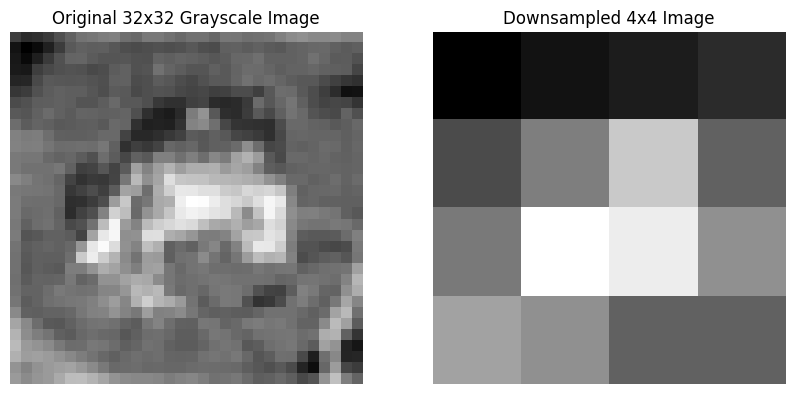

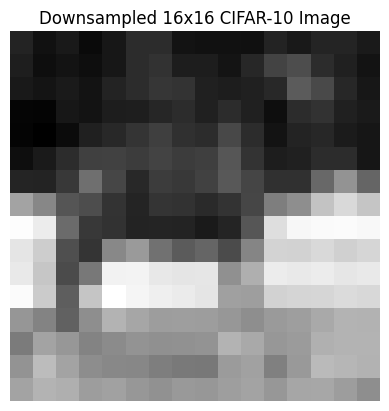

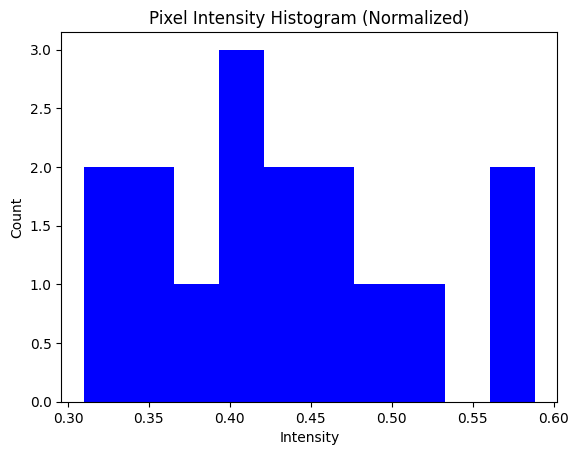

In [23]:
import pennylane as qml
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Amplitude Encoding requires log2(N) qubits
image_size = 16
n_pixels = image_size ** 2
n_qubits = int(np.log2(n_pixels))  # 8 qubits

dev = qml.device('default.qubit', wires=n_qubits)
@qml.qnode(dev)
def amplitude_encoded_circuit(image):
    qml.AmplitudeEmbedding(features=image / np.linalg.norm(image), wires=range(n_qubits), normalize=False)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

# Preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)

# Loading one image
images, labels = next(iter(trainloader))
image_tensor = images[0].squeeze()  # Shape (16, 16)
image_np = image_tensor.numpy().flatten()

# Run quantum circuit
result = amplitude_encoded_circuit(image_np)
print("Amplitude Encoding (Z-expectation):", result)

# Load CIFAR-10 without resize for comparison
original_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
original_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=original_transform)
original_image = original_trainset[0][0][0].numpy()  # Get 32x32 grayscale

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original 32x32 Grayscale Image")
ax[0].axis('off')

ax[1].imshow(flat_image.reshape(4,4), cmap='gray')
ax[1].set_title("Downsampled 4x4 Image")
ax[1].axis('off')
plt.show()



# Visualize
plt.imshow(images[0][0], cmap='gray')
plt.title("Downsampled 16x16 CIFAR-10 Image")
plt.axis('off')
plt.show()

plt.hist(flat_image, bins=10, color='blue')
plt.title("Pixel Intensity Histogram (Normalized)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.show()

Basis Encoding Result (first 10 values): [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(-1.0), np.float64(1.0), np.float64(1.0), np.float64(-1.0)]


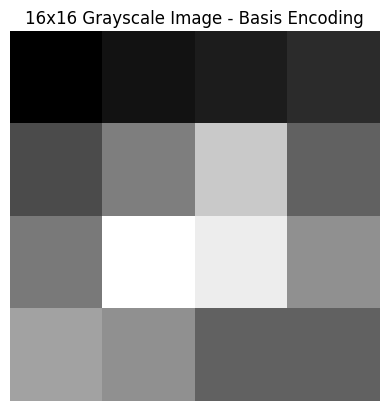

In [29]:
import pennylane as qml
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

image_size = 4
n_pixels = image_size ** 2  # 16 pixels
dev = qml.device('default.qubit', wires=n_pixels)


# Load and preprocess image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
image = dataset[0][0].squeeze().numpy()
flat_image = image.flatten()

# Quantum basis encoding
def basis_encoding(img):
    for i, val in enumerate(img):
        if val > 0.5:
            qml.PauliX(wires=i)

@qml.qnode(dev)
def basis_encoded_circuit(img):
    basis_encoding(img)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_pixels)]

# Run circuit
result = basis_encoded_circuit(flat_image)
print("Basis Encoding Result (first 10 values):", result[:10])

# Visualization
plt.imshow(image, cmap='gray')
plt.title("16x16 Grayscale Image - Basis Encoding")
plt.axis('off')
plt.show()


Angle Encoding Result (Z-Expectations): [np.float64(1.0000002156950394), np.float64(0.9756265426691055), np.float64(0.9379999696061262), np.float64(0.862314780782196), np.float64(0.5984725225711085), np.float64(0.022122206997525484), np.float64(-0.7877081446143357), np.float64(0.36730172941590156), np.float64(0.06632309818766813), np.float64(-1.0000002156950347), np.float64(-0.9756265751681297), np.float64(-0.19780189743252385), np.float64(-0.4080836738774444), np.float64(-0.19780189743252452), np.float64(0.3673017294159022), np.float64(0.3673017294158966)]


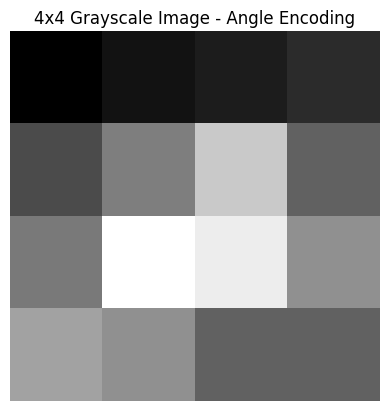

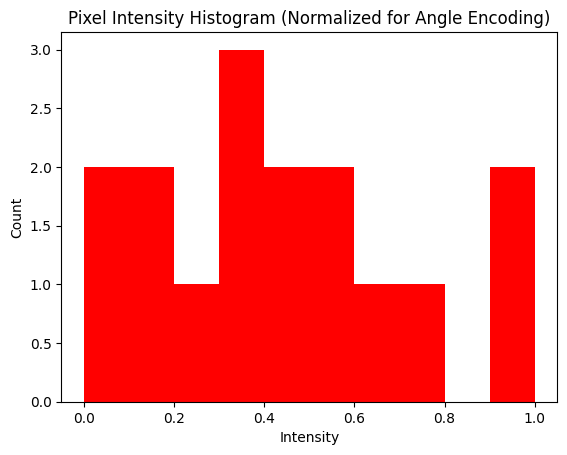

In [27]:
import pennylane as qml
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Setup
image_size = 4  # 4x4 = 16 pixels
n_pixels = image_size ** 2
dev = qml.device('default.qubit', wires=n_pixels)

# Preprocessing: Grayscale + Resize to 4x4
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
image = dataset[0][0].squeeze().numpy()
flat_image = image.flatten()

# Normalize to [0, 1]
normalized = (flat_image - flat_image.min()) / (flat_image.max() - flat_image.min())

# Angle Encoding Function
def angle_encoding(image):
    for i, val in enumerate(image):
        qml.RY(np.pi * val, wires=i)

@qml.qnode(dev)
def angle_encoded_circuit(image):
    angle_encoding(image)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_pixels)]

# Run circuit
result = angle_encoded_circuit(normalized)
print("Angle Encoding Result (Z-Expectations):", result)

# Visualize
plt.imshow(image, cmap='gray')
plt.title("4x4 Grayscale Image - Angle Encoding")
plt.axis('off')
plt.show()

# Optional: Histogram of input values
plt.hist(normalized, bins=10, color='red')
plt.title("Pixel Intensity Histogram (Normalized for Angle Encoding)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.show()
